# Model Training Notebook
### Model Development and Evaluation

In [28]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

In [19]:
# Load processed data and original data for country mapping
processed_data = pd.read_csv('../data/processed_train.csv')
original_data = pd.read_csv('../data/car_purchasing.csv', encoding='ISO-8859-1')

In [20]:
# Extract features and target
X = processed_data.drop('car purchase amount', axis=1)
y = processed_data['car purchase amount']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100),
    'XGBoost': XGBRegressor(),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50))
}

In [21]:
# Model training and evaluation
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = {
        'Model': name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    results.append(metrics)
    
results_df = pd.DataFrame(results)

c:\Users\nxyan\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [22]:
# Cross-validation
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_scores[name] = scores.mean()

c:\Users\nxyan\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nxyan\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nxyan\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nxyan\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\nxyan\miniconda3\Lib\site-packages\sklearn\neural_network\_

In [23]:
# Customer segmentation
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X[['annual Salary', 'net worth']])



In [24]:
# Analyze clusters
cluster_analysis = pd.DataFrame({
    'Annual Salary': X['annual Salary'],
    'Net Worth': X['net worth'],
    'Cluster': clusters,
    'Purchase Amount': y
})



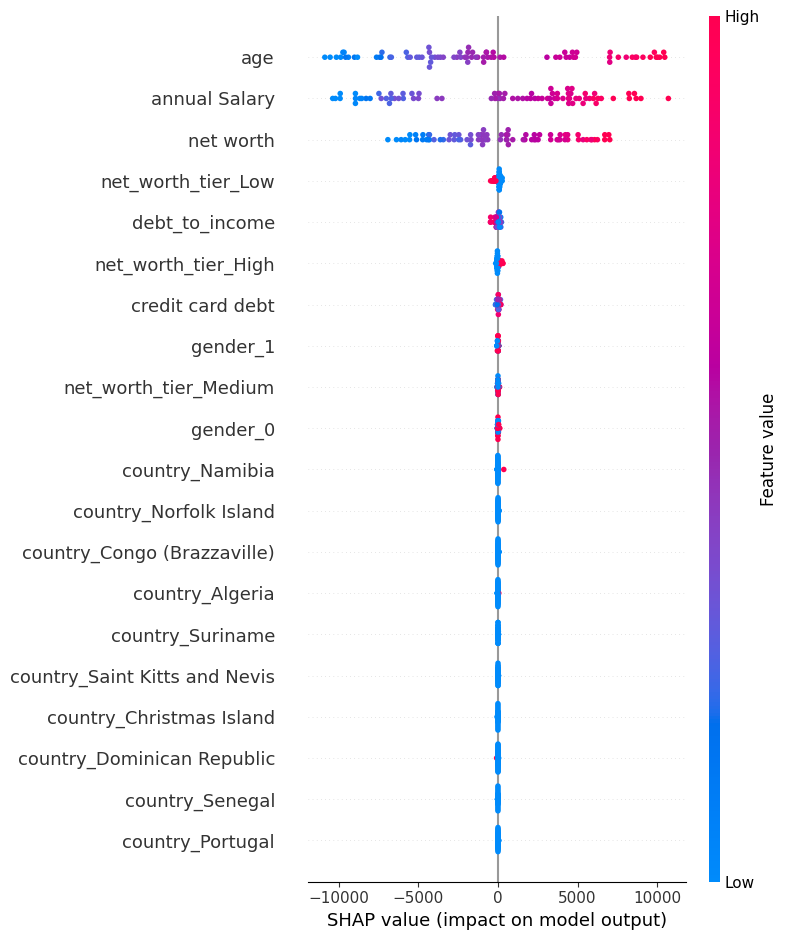

In [25]:
# SHAP analysis (for best model)
best_model = RandomForestRegressor(n_estimators=100)
best_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))

shap.summary_plot(shap_values, X_test)
plt.tight_layout()
plt.savefig('../reports/figures/shap_summary.png', dpi=300)
plt.close()

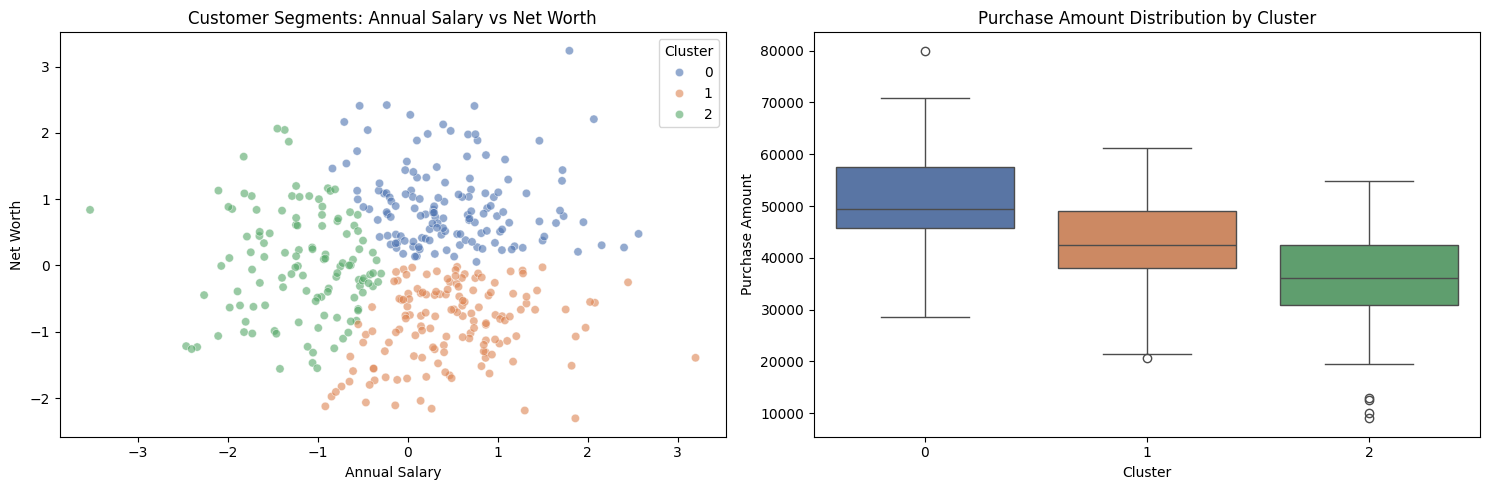


Cluster Statistics:
        Annual Salary Net Worth Purchase Amount      
                 mean      mean            mean count
Cluster                                              
0                0.49      0.91        51707.63   139
1                0.49     -0.89        42912.27   143
2               -1.17      0.01        36056.05   118


In [40]:
# Enhanced cluster analysis visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot of Annual Salary vs Net Worth colored by clusters
plt.subplot(1, 2, 1)
sns.scatterplot(data=cluster_analysis, 
                x='Annual Salary', 
                y='Net Worth',
                hue='Cluster',
                palette='deep',
                alpha=0.6)
plt.title('Customer Segments: Annual Salary vs Net Worth')

# Plot 2: Average Purchase Amount by Cluster
plt.subplot(1, 2, 2)
sns.boxplot(data=cluster_analysis,
            x='Cluster',
            y='Purchase Amount',
            hue='Cluster',
            palette='deep',
            legend=False)
plt.title('Purchase Amount Distribution by Cluster')

plt.tight_layout()
plt.savefig('../reports/figures/cluster_analysis.png', dpi=300)
plt.show()
plt.close()

# Display average metrics for each cluster
cluster_stats = cluster_analysis.groupby('Cluster').agg({
    'Annual Salary': 'mean',
    'Net Worth': 'mean',
    'Purchase Amount': ['mean', 'count']
}).round(2)

print("\nCluster Statistics:")
print(cluster_stats)

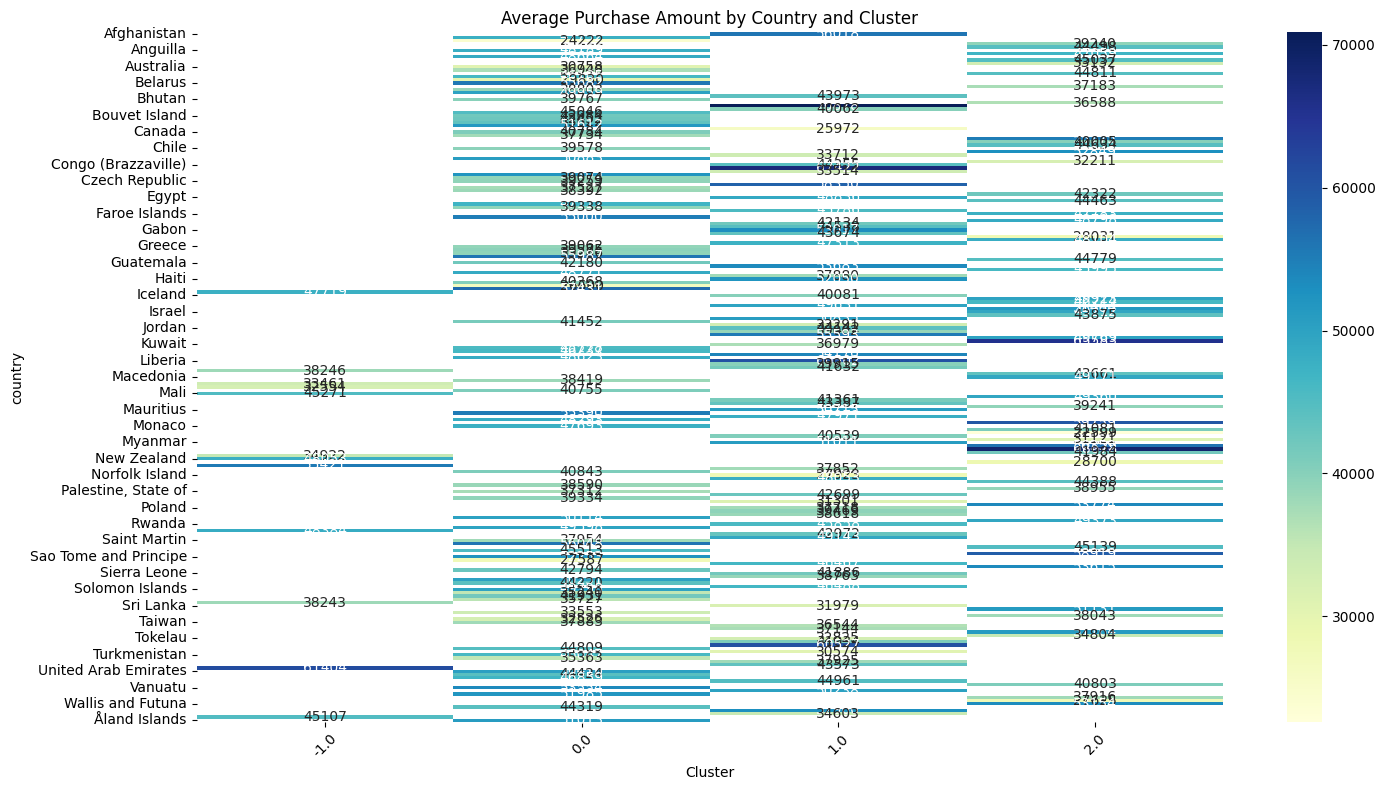

In [39]:
# Add cluster information to original data
original_data.loc[0:399, 'Cluster'] = clusters  # Only assign to the rows where we have cluster data

# Geographic heatmap
country_stats = original_data.groupby('country').agg({
    'car purchase amount': 'mean',
    'Cluster': lambda x: x.mode()[0] if not x.isna().all() else -1  # Handle missing clusters
}).reset_index()

plt.figure(figsize=(15, 8))
sns.heatmap(pd.pivot_table(country_stats, 
                        values='car purchase amount', 
                        index='country', 
                        columns='Cluster'),
            annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Average Purchase Amount by Country and Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/geo_heatmap.png', dpi=300)
# Display the plot
plt.show()
plt.close()




In [41]:
# Save best model
joblib.dump(best_model, '../models/best_model.pkl')

['../models/best_model.pkl']